# How To Run a Jackknife Using Hera_Stats

This code shows how to use the jackknifing class in hera_stats.

First, I will run everything systematically. Later, all at once in an overarching function.

In [1]:
# Import stuff
%matplotlib inline
import hera_stats as hs
import matplotlib.pyplot as plt

/users/drocha/Python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
jk = hs.jackknife()

In [3]:
# Load UVData miriad file from filepath
filepath = "../hera_stats/data/gaussian.N18.2018-06-06.06_15_48/"
jk.load_uvd(filepath)

In [4]:
# Set some specifications
spw_ranges = [(600,700)]
baseline = (0,1)
pols = ("XX","XX")
beampath = "../hera_stats/data/NF_HERA_Beams.beamfits"
taper = "blackman-harris"

# Calculate power spectra
jk.calc_uvp(spw_ranges,baseline=baseline,pols=pols,beampath=beampath,taper=taper)

(0, 0, 1, 'XX') --- (1, 1, 2, 'XX')


Once calc_uvp is done, the output is stored as a class variable. Jackknives can then be done on the power spectra that are now present.

In [5]:
# Split antenna into two groups
uvpl,grps,n_pairs = jk.jackknives.split_ants(n_jacks=1)

In [6]:
dlys, avspec1, errs1 = jk.bootstrap_errs_once(uvpl[0][0],pol="xx",n_boots=100)
dlys, avspec2, errs2 = jk.bootstrap_errs_once(uvpl[0][1],pol="xx",n_boots=100)

Text(0.5,1,'Sample Jackknife Pair')

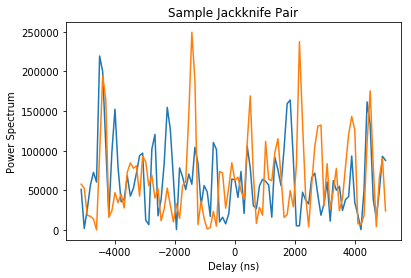

In [7]:
plt.plot(dlys,avspec1)
plt.plot(dlys,avspec2)
plt.xlabel("Delay (ns)")
plt.ylabel("Power Spectrum")
plt.title("Sample Jackknife Pair")

Now, using the more concise function...

In [8]:
jk.clock_reset()

# Load UVData miriad file from filepath
filepath = "../hera_stats/data/gaussian.N18.2018-06-06.06_15_48/"
jk.load_uvd(filepath)

# Set some specifications
spw_ranges = [(600,700)]
baseline = (0,1)
pols = ("XX","XX")
beampath = "../hera_stats/data/NF_HERA_Beams.beamfits"
taper = "blackman-harris"

dic = jk.jackknife(jk.jackknives.split_ants,1,spw_ranges,beampath,baseline=baseline,pols=pols,
                   taper=taper, verbose=True,returned=True)

(0, 0, 1, 'XX') --- (1, 1, 2, 'XX')
Time taken:
Load Time: 0 min, 2.3 sec
Pspec-ing: 0 min, 5.6 sec
Bootstrapping: 0 min, 0.2 sec
Total: 0 min, 8.1 sec


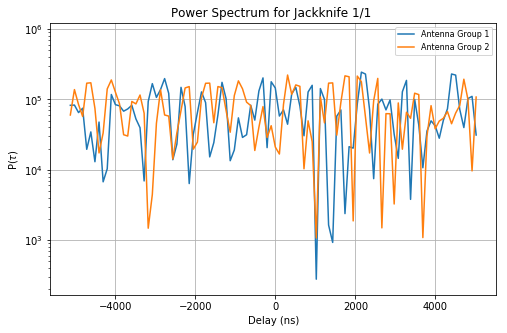

In [9]:
# This time we will plot with hera_pspec.plots
pl = hs.plots()
pl.load_dic(dic)

pl.plot_spectra()